<a href="https://colab.research.google.com/github/jacobadodge/Spring2024_CVENG_8160/blob/main/2D_GRU_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# MOUNT DRIVE

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# CHAGNE DIRECTORY

%cd '/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)'

/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)


In [ ]:
# IMPORT NEEDED MODULES

import pandas as pd
import random, math
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from scipy import fftpack
import torch.utils.data as utils
import os
from sklearn.metrics import mean_absolute_percentage_error
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

In [ ]:
# Already downloaded data, no need to run again

# !gdown 'https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN'
# !gdown 'https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i'

Downloading...
From: https://drive.google.com/uc?id=1E_qqe7kfvfApM4hCOBMPoXhyEPyrUJkN
To: /content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)/train.zip
100% 8.67M/8.67M [00:00<00:00, 20.4MB/s]
Downloading...
From: https://drive.google.com/uc?id=1j-3-lHegY--FDHKZvz86HBtilV2dsP-i
To: /content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)/test.zip
100% 459k/459k [00:00<00:00, 89.1MB/s]


In [ ]:
# Already unzipped data, no need to run again

# !unzip 'train.zip' -d '.'
# !unzip 'test.zip' -d '.'

Archive:  train.zip
  inflating: ./tps_df.pkl            
  inflating: ./__MACOSX/._tps_df.pkl  
Archive:  test.zip
  inflating: ./test_data/tps_5.pkl   
  inflating: ./test_data/tps_2.pkl   
  inflating: ./test_data/tps_6.pkl   
  inflating: ./test_data/tps_4.pkl   
  inflating: ./test_data/tps_15.pkl  
  inflating: ./test_data/tps_7.pkl   
  inflating: ./test_data/tps_1.pkl   
  inflating: ./test_data/tps_12.pkl  
  inflating: ./test_data/tps_8.pkl   
  inflating: ./test_data/tps_3.pkl   
  inflating: ./test_data/tps_9.pkl   
  inflating: ./test_data/tps_13.pkl  
  inflating: ./test_data/tps_11.pkl  
  inflating: ./test_data/tps_10.pkl  
  inflating: ./test_data/tps_14.pkl  


In [ ]:
# SPLIT DATA INTO TEST AND TRAIN

df = pd.read_pickle('tps_df.pkl')
test = .2
df_len = df.shape[0]
df_train, df_test = df.iloc[0:df_len - int(test*df_len)], df.iloc[df_len - int(test*df_len):]
df_train.to_csv('data/train2.csv', index = False)  # save training data as 'train.csv' in 'data' folder
df_test.to_csv('data/test2.csv', index = False)  # save testing data as 'test.csv' in 'data' folder
df_train.shape, df_test.shape

((1012750, 8), (253187, 8))

In [ ]:
class TrafficForecast():
    def __init__(self,csv_path, window, horizon):
        self.csv_path = csv_path
        self.window = window
        self.horizon = horizon
        self.df = None
        self.seg_ids = None
        self.inputs = []
        self.targets = []


        df = pd.read_csv(self.csv_path)
        df['time'] = pd.to_datetime(df['time'])
        df['unix_timestamp'] = df['time'].astype(int) / 10**9
        df['dow'] = df['time'].dt.weekday
        df['hour'] = df['time'].dt.hour
        df['min'] = df['time'].dt.minute
        self.df = df.sample(frac=1).reset_index(drop=True)
        self.seg_ids = self.df['segmentID'].unique()
        self.setup_forecast() # call 'setup_forecast()' function

    def setup_forecast(self):
        for segid in self.seg_ids:
            df_seg_id = self.df[self.df['segmentID'] == segid]
            df_seg_id = df_seg_id.sort_values(by='time',ascending=True)
            df_seg_id = df_seg_id.fillna(method="ffill")
            TI_series = df_seg_id['TrafficIndex_GP'].values
            h_series = df_seg_id['hour'].values # get data from 'hour' column like 'TrafficIndex_GP'
            for t in range(0,len(TI_series)-(self.window+self.horizon)):
                x = TI_series[t:t+self.window]
                h = h_series[t:t+self.window]
                y = TI_series[t+self.window:(t+self.window+self.horizon)]
                x_cat = np.dstack([x,h])
                # print(x_cat.shape)
                self.inputs.append(x_cat)
                self.targets.append(y)

    def __len__(self):
        return len(self.inputs)


    def __getitem__(self,idx):
        X = torch.tensor(self.inputs[idx],dtype=torch.float32).reshape(self.window, 2)
        y=torch.tensor(self.targets[idx],dtype=torch.float32)

        return {'inputs':X,'outputs':y}


In [ ]:
# CREATE OBJECT FOR TRIANING AND TESTING

tobj_train = TrafficForecast('/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)/data/train2.csv',36,36)
tobj_test = TrafficForecast('/content/drive/MyDrive/Masters/Semester 1/CVENG_8160_ADV_RES_METH_TRANS/module 06 (time series forecasting)/data/test2.csv',36,36)

In [ ]:
bs = 1024
dataloader_train = DataLoader(tobj_train, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)
dataloader_test = DataLoader(tobj_test, batch_size=bs, shuffle=False, num_workers=4,drop_last=True)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
# n x t x d --> 3x3x1 (batch size, window, depth)
# TI = [1,2,3,4,5,6,7,8,9]
# sample1: [1,2,3]-->[4,5,6]
# sample2: [2,3,5]-->[5,6,7]
# sample3: [3,4,5]-->[6,7,8]

In [ ]:
# VIEW SHAPE OF TESTING AND TRAINING DATA

for idx, data in enumerate(dataloader_train):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx == 5:
      break
for idx, data in enumerate(dataloader_test):
    print (data['inputs'].shape,data['outputs'].shape)
    if idx == 5:
      break

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])
torch.Size([1024, 36, 2]) torch.Size([1024, 36])


In [ ]:
# torch.Size([1024, 36, 1]) --> n x t x d --> 1024 x 36 x 1 --> batch size = 1024; window = 36; depth = 1

In [ ]:
# USE GPU IF AVAILABLE

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from models import MyLSTM, MyGRU

In [ ]:
# CHANGE MODEL TO 'MyGRU' or 'MyLSTM'

model = MyGRU(n_inputs=2, n_hidden=10, n_rnnlayers=2, n_outputs=36)
model.to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
mean_loss = []
losses = []
test_losses = []
mean_test_loss = []
n_epochs = 3
# ts = ToTensor()
for it in tqdm(range(n_epochs)):

  # TRAINING MODEL
  for i_batch, sample_batched in enumerate(dataloader_train):
    optimizer.zero_grad()
    outputs = model(sample_batched['inputs'].to(device))
    loss = criterion(outputs, sample_batched['outputs'].to(device))
    losses.append(loss.item())
    loss.backward()
    optimizer.step()

  # TESTING MODEL
  for i_test,sample_test in enumerate(dataloader_test):
      outputs = model(sample_test['inputs'].to(device))
      test_loss = criterion(outputs, sample_test['outputs'].to(device))
      test_losses.append(test_loss.item())


  if (it+1) % 1 == 0:
    print(f'Epoch {it+1}/{n_epochs}, Training Loss: {np.mean(losses):.4f}, Testing Loss: {np.mean(test_losses):.4f}')

  0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
 33%|███▎      | 1/3 [00:35<01:11, 36.00s/it]

Epoch 1/3, Training Loss: 0.0788, Testing Loss: 0.0017


 67%|██████▋   | 2/3 [01:08<00:33, 33.68s/it]

Epoch 2/3, Training Loss: 0.0461, Testing Loss: 0.0017


100%|██████████| 3/3 [01:40<00:00, 33.57s/it]

Epoch 3/3, Training Loss: 0.0352, Testing Loss: 0.0017


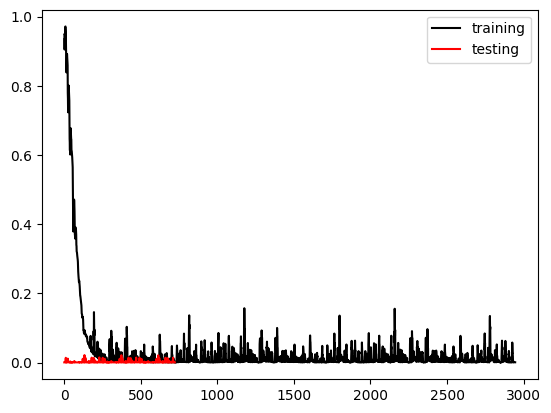

In [ ]:
plt.plot(losses,'k',label='training')
plt.plot(test_losses, 'r', label = 'testing')
plt.legend()

# Above Program for Assignment: Use two dimensions for training and testing; Split data into test data and training data